In [1]:
from sys import path
path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
from src.utils import load, plot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

Using TensorFlow backend.


In [2]:
def timestamp_model_name(prefix='model_', suffix=''):
    from datetime import datetime
    
    now = datetime.now()
    year, month, day = now.year, now.month, now.day
    hour, minute, second = now.hour, now.minute, now.second
    
    return '{}{}-{}-{}_{}-{}-{}{}.hdf5'.format(prefix, year, month, day, hour, minute, second, suffix)

# Load Model 

In [3]:
model = load_model('models/model_2019-6-17_12-29-19.hdf5')

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
______________________

# 11. Varied Background

In [4]:
mrk_files = load.mrk_files_from_folder('data/augmentation/11-varied_bgd/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

9000 of 9000


In [5]:
x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(np.unique(y, return_counts=True))

9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
(array([-1,  0,  1]), array([3000, 3000, 3000], dtype=int64))


In [6]:
enc = LabelEncoder()
y = enc.fit_transform(y)
print(np.unique(y, return_counts=True))

(array([0, 1, 2], dtype=int64), array([3000, 3000, 3000], dtype=int64))


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(8100, 224, 224, 3) (8100,)
(900, 224, 224, 3) (900,)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 32)      128       
__________

8100/8100 [==============================] - 6s 736us/step - loss: 0.5566 - acc: 0.7573 - val_loss: 0.5901 - val_acc: 0.7422

Epoch 00022: val_acc did not improve from 0.76556
Epoch 23/30
8100/8100 [==============================] - 6s 738us/step - loss: 0.5593 - acc: 0.7581 - val_loss: 0.6202 - val_acc: 0.7156

Epoch 00023: val_acc did not improve from 0.76556
Epoch 24/30
8100/8100 [==============================] - 6s 739us/step - loss: 0.5540 - acc: 0.7549 - val_loss: 0.5801 - val_acc: 0.7689

Epoch 00024: val_acc improved from 0.76556 to 0.76889, saving model to models/model_2019-7-8_13-0-48_11_varied-bgd.hdf5
Epoch 25/30
8100/8100 [==============================] - 6s 738us/step - loss: 0.5538 - acc: 0.7594 - val_loss: 0.5686 - val_acc: 0.7689

Epoch 00025: val_acc did not improve from 0.76889
Epoch 26/30
8100/8100 [==============================] - 6s 741us/step - loss: 0.5510 - acc: 0.7623 - val_loss: 0.5683 - val_acc: 0.7689

Epoch 00026: val_acc did not improve from 0.76889
Ep

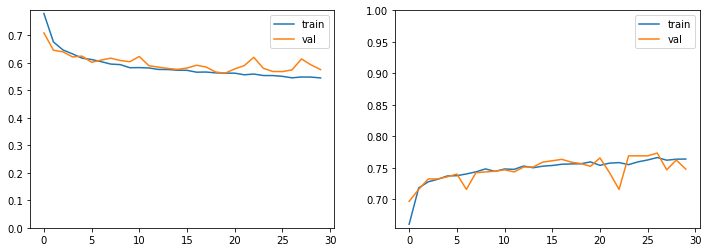

In [8]:
outputs = Dense(units=3, activation='softmax', name='varied_background')(encoder.output)
model = Model(inputs=encoder.inputs, outputs=outputs)

for layer in model.layers:
    layer.trainable = (layer.name == 'varied_background')

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

FILE_MODEL = 'models/' + timestamp_model_name(suffix='_11_varied-bgd')
list_callbacks = [
    EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(FILE_MODEL, monitor='val_acc', verbose=1, save_best_only=True)
]

hist = model.fit(x_train / 255, y_train, 
                 batch_size=32, 
                 epochs=30, 
                 validation_data=(x_val / 255, y_val), 
                 callbacks=list_callbacks)

plot.keras_hist(hist.history)

In [9]:
y_pred = model.predict(x_val / 255).argmax(axis=1)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[253  18  29]
 [ 59 237   4]
 [107  10 183]]
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       300
           1       0.89      0.79      0.84       300
           2       0.85      0.61      0.71       300

    accuracy                           0.75       900
   macro avg       0.78      0.75      0.75       900
weighted avg       0.78      0.75      0.75       900



# Error Analysis 

(18, 224, 224, 3) (18,)


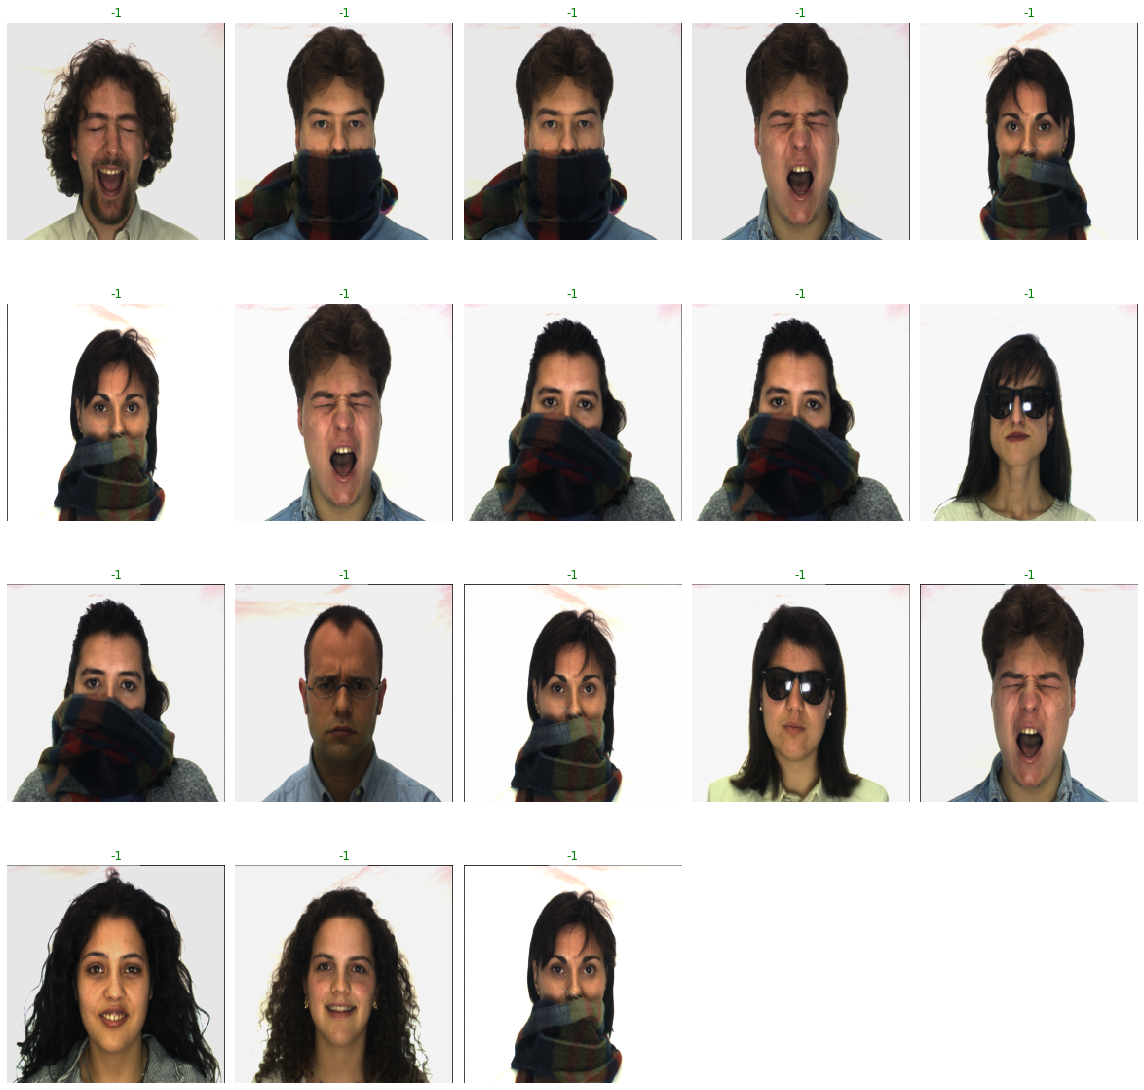

In [13]:
y_val_dec = enc.inverse_transform(y_val)
y_pred_dec = enc.inverse_transform(y_pred)

cond = (y_val_dec == -1) & (y_pred_dec == 0)
im_errors = x_val[cond]
y_true = y_val_dec[cond]
print(im_errors.shape, y_true.shape)

plot.image_batch(im_errors[:, :, :, ::-1], y_true, n_cols=5, figsize=(16, 16))